In [17]:
data_dir = '/scratch/fs999/shamoutlab/data/mimic-iv-extracted/'
img_dir = '/scratch/fs999/shamoutlab/data/'
code_dir = '/scratch/se1525/mml-ssl'
task = 'phenotyping'

# Import libraries
import sys
#sys.path.append(f'{code_dir_medfuse}')
import numpy as np
import argparse
import os
import importlib as imp
import re
from pathlib import Path
import pandas as pd
import neptune.new as neptune
from pathlib import Path
import matplotlib.pyplot as plt


# ## Visualization
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# from tqdm.notebook import tqdm
# import matplotlib
# matplotlib.use('Agg')

# Import Pytorch 
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision


## Performance metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, average_precision_score

# Import custom functions
import custom_parser as par
import data_utils as prep
# from fusion_trainer_farah import FusionTrainer
# from mmtm_trainer import MMTMTrainer
# from daft_trainer import DAFTTrainer


# Import functions from MedFuse
from datasets.ehr_dataset import get_datasets
from datasets.cxr_dataset import get_cxr_datasets, visualize_transforms_simclr
from datasets.fusion import load_cxr_ehr
from ehr_preprocess import ehr_funcs
import load_tasks as tasks
from PIL import Image
from simclr_trainer_gpu import SimCLR, train, test, prepare_data_features#, LogisticRegression, train_logreg

#sys.path.append('/home/shamoutlab/.local/bin')

import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%reload_ext autoreload

In [19]:
parser = par.initiate_parsing()
        

args = parser.parse_args(['--save_dir', '/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/phenotyping/models',
'--vision-backbone', 'resnet34' ,
'--epochs', '300', '--transforms_cxr', 'simclrv2', '--temperature', '0.01',
'--load_state', 'SIMCLR-760276_epoch_148', #'T-SIMCLR-1042373_epoch_20'
'--batch_size', '1', '--lr' ,'0.5' ,
'--pretrain_type' ,'simclr' , '--width', '1',
'--mode' ,'train' ,
'--fusion_type', 'None', '--beta_infonce', '--fusion_layer' , '0']) #, 


# 1042373

print(args)

Namespace(batch_size=1, beta_1=0.9, beta_infonce=True, cov_coeff=1, crop=224, cxr_data_root='/scratch/fs999/shamoutlab/data/physionet.org/files/mimic-cxr-jpg/2.0.0', data_pairs='paired', data_ratio=1.0, dataset='evaluation_task', device='0', dim=256, dropout=0.0, ehr_data_root='/scratch/fs999/shamoutlab/data/mimic-iv-extracted', epochs=300, epochs_linearclassify=100, eval_epoch=0, eval_set='val', file_name=None, finetune=False, fusion_layer=0, fusion_type='None', hidden_dim=128, imputation='previous', job_number='0', labels_set='pheno', layer_after=4, layers=1, linearclassify=False, load_state='SIMCLR-760276_epoch_148', load_state_cxr=None, load_state_ehr=None, load_state_lc=None, load_state_simclr=None, lr=0.5, lr_linearclassify=0.0001, mmtm_ratio=4, mode='train', normalizer_state=None, num_classes=25, num_gpu=1, overwrite_classifier=False, pretrain_type='simclr', pretrained=False, rec_dropout=0.0, resize=256, save_dir='/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/chec

In [20]:
discretizer, normalizer = ehr_funcs(args)
ehr_train_ds, ehr_val_ds, ehr_test_ds = get_datasets(discretizer, normalizer, args)
print(len(ehr_train_ds))
print(len(ehr_val_ds))
print(len(ehr_test_ds))

42628
4802
11914


In [21]:
cxr_train_ds, cxr_val_ds, cxr_test_ds = get_cxr_datasets(args)
print(len(cxr_train_ds))

Appling SimCLR image transforms...
325188


In [22]:
train_dl, val_dl, test_dl = load_cxr_ehr(args, ehr_train_ds, ehr_val_ds, cxr_train_ds, cxr_val_ds, ehr_test_ds, cxr_test_ds)


Number of CXR images= 377110
Number of ICU stays= 59372
Number of CXR associated with ICU stay based on subject ID= 368350
Number of unique CXR dicoms= 181195
Number of unique CXR study id= 122087
Mean time cxr - intime=  68.3979428307123
Minimum time = 0.009
Maximum time = 2368.942
Excluding CXR with missing radiology reports =  7756
7756
882
2166


In [23]:
for x, img, targets_ehr, targets_cxr, seq_length, pairs, time_diff in val_dl:   #
    print(x, img, targets_ehr, targets_cxr, seq_length, pairs,  time_diff) #
    break

[[[ 1.          0.         -0.03036311 ...  1.          0.
    1.        ]
  [ 1.          0.          0.03723598 ...  0.          0.
    0.        ]
  [ 1.          0.          0.00118313 ...  0.          0.
    0.        ]
  ...
  [ 1.          0.          0.02371616 ...  1.          0.
    0.        ]
  [ 1.          0.          0.1318747  ...  0.          0.
    0.        ]
  [ 1.          0.          0.1318747  ...  0.          0.
    0.        ]]] tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.1529, 0.1608, 0.1725],
          [0.0196, 0.0196, 0.0314,  ..., 0.1804, 0.2157, 0.2471],
          [0.0196, 0.0392, 0.0588,  ..., 0.2941, 0.3294, 0.3294],
          ...,
          [0.0588, 0.0588, 0.0353,  ..., 0.7529, 0.8157, 0.7961],
          [0.0588, 0.0588, 0.0353,  ..., 0.7529, 0.8078, 0.7961],
          [0.0667, 0.0627, 0.0431,  ..., 0.7608, 0.7961, 0.8078]],

         [[0.0235, 0.0235, 0.0235,  ..., 0.1529, 0.1608, 0.1725],
          [0.0196, 0.0196, 0.0314,  ..., 0.1804, 0.2157, 0.2471

In [24]:
img_dir = args.cxr_data_root+'/resized/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg'
orig_img = Image.open(img_dir).convert('RGB')
img_array, titles = visualize_transforms_simclr(args, orig_img)

<PIL.Image.Image image mode=RGB size=512x615 at 0x1553EBEAC9B0>


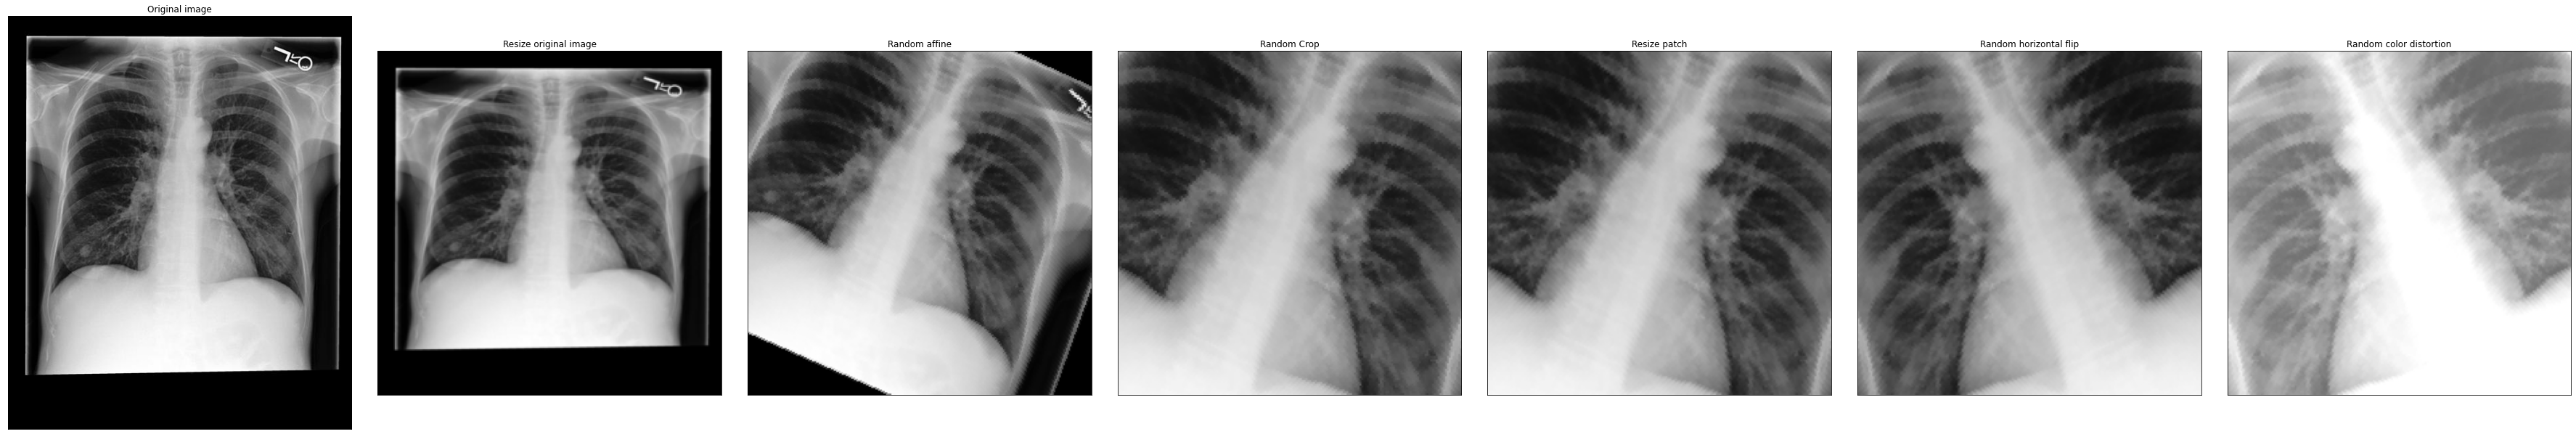

In [25]:
def plot(imgs, with_orig=True, row_title=None):
    num_cols = len(imgs)
    fig, axs = plt.subplots(nrows=1, ncols=num_cols, squeeze=False,figsize=(50,50))
    for i in range(0, len(imgs)):
        ax = axs[0, i]
        ax.imshow(imgs[i].permute(1,2,0))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=row_title[i])
        
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()


plot(img_array, row_title = titles)

# Understand properties of multimodal representations

In [26]:
model = SimCLR(args, val_dl)

None
Total number of checkpoint params = 230
Total number of current model params = 230
Total number params loaded for model weights = 230


In [27]:
print(args.batch_size)
len(val_dl)


1


882

In [28]:
from simclr_trainer_gpu import prepare_data_features
val_dl_pr = prepare_data_features('cuda:0', model, val_dl, args.batch_size, args.fusion_layer, 'lineareval')


ValueError: too many values to unpack (expected 6)

In [144]:
# Create a matrix of the validation embeddings
z_ehr = []
z_cxr = []
time = []
x=0
for item in val_dl_pr:
    if x == 0:
        z_ehr = item[0].tolist()
        z_cxr = item[1].tolist()
        time = item[4].tolist()
    else:
        z_ehr = z_ehr + item[0].tolist()
        z_cxr = z_cxr + item[1].tolist()
        time = time + item[4].tolist()
    x+=1


In [145]:
df = pd.DataFrame({'time': time, 'z_ehr': z_ehr, 'z_cxr': z_cxr})
df_24 = df.loc[df.time <24]
print(len(df_24))
df_48 = df.loc[(df.time >= 24) & (df.time <48)]
print(len(df_48))
df_72 = df.loc[(df.time >= 48) & (df.time <72)]
print(len(df_72))
df_96 = df.loc[(df.time >= 72) & (df.time <96)]
print(len(df_96))
#df_120 = df.loc[(df.time >= 96) & (df.time < 120)].sample(50)
#print(len(df_120))
df_g120 = df.loc[(df.time >= 120)]

352
204
103
61


## Investigate covariance across embeddings within a modality

In [146]:
def svd (z):
    e = np.array(z).T
    cov = np.cov(e)
    u, s, vh = np.linalg.svd(cov, full_matrices=True)
    return s

def svd_mm (z1, z2):
    e1 = np.array(z1).T
    e2 = np.array(z2).T
    cov = np.cov(e1, e2)
    u, s, vh = np.linalg.svd(cov, full_matrices=True)
    return s


def arr (z):
    q = np.array([np.array(x) for x in z])
    return q

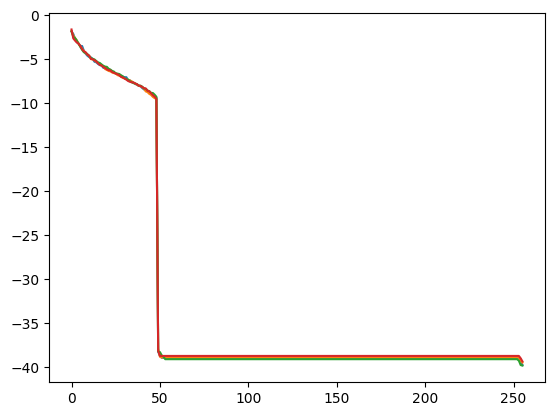

In [131]:
s_24 = svd_mm(arr(df_24.z_ehr.values), arr(df_24.z_cxr.values))
plt.plot(np.log(s_24), label = '24 hours')

s_48 = svd_mm(arr(df_48.z_ehr.values), arr(df_48.z_cxr.values))
plt.plot(np.log(s_48), label = '48 hours')

s_72 = svd_mm(arr(df_72.z_ehr.values), arr(df_72.z_cxr.values))
plt.plot(np.log(s_72), label = '72 hours')

s_96 = svd_mm(arr(df_96.z_ehr.values), arr(df_96.z_cxr.values))
plt.plot(np.log(s_96), label = '96 hours')

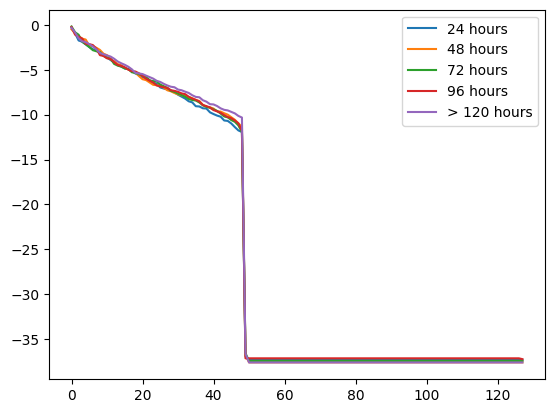

In [120]:
## Modality 1: EHR

s_24 = svd(arr(df_24.z_ehr.sample(50).values))
plt.plot(np.log(s_24), label = '24 hours')

s_48 = svd(arr(df_48.z_ehr.sample(50).values))
plt.plot(np.log(s_48), label = '48 hours')

s_72 = svd(arr(df_72.z_ehr.sample(50).values))
plt.plot(np.log(s_72), label = '72 hours')

s_96 = svd(arr(df_96.z_ehr.sample(50).values))
plt.plot(np.log(s_96), label = '96 hours')

#s_120 = svd(arr(df_120.z_ehr.sample(50).values))
#plt.plot(np.log(s_120), label = '120 hours')

s_g120 = svd(arr(df_g120.z_ehr.sample(50).values))
plt.plot(np.log(s_g120), label = '> 120 hours')

plt.legend()

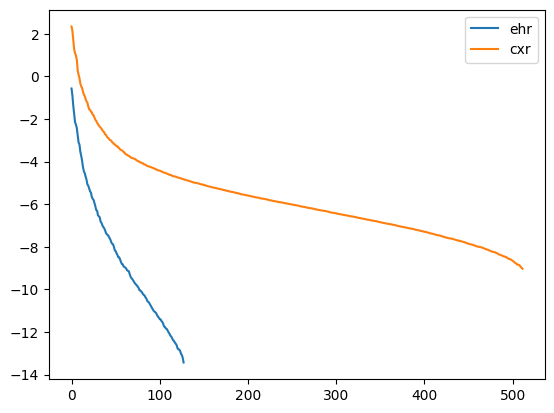

In [147]:
s_ehr = svd(arr(df.z_ehr.values))
plt.plot(np.log(s_ehr), label = 'ehr')

s_cxr = svd(arr(df.z_cxr.values))
plt.plot(np.log(s_cxr), label = 'cxr')

plt.legend()

(128, 128)


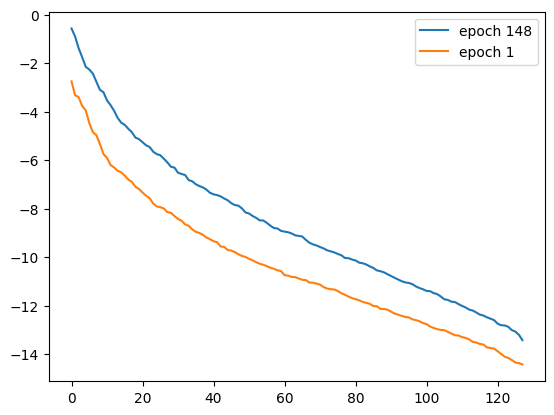

In [49]:
## Modality 1: EHR

e_ehr = np.array(z_ehr).T
cov_ehr = np.cov(e_ehr)
print(np.shape(cov_ehr))

u, s_ehr_1, vh = np.linalg.svd(cov_ehr, full_matrices=True)
plt.plot(np.log(s_ehr), label='epoch 148')
plt.plot(np.log(s_ehr_1), label = 'epoch 1')
# plt.plot(np.log(s_ehr_3), label = 'epoch 100')
# plt.plot(np.log(s_ehr_4), label = 'epoch 50')
# plt.plot(np.log(s_ehr_5), label = 'epoch 20')


plt.legend()

(512, 512)


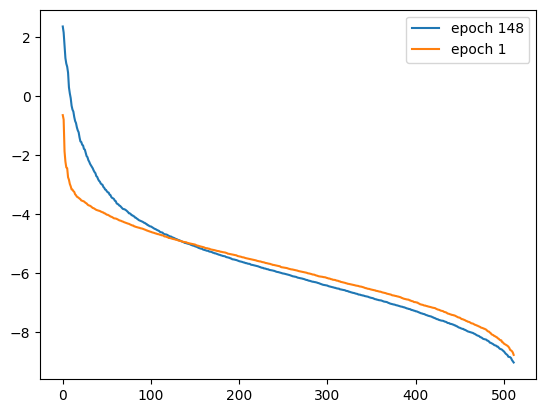

In [37]:
## Modality 2: CXR

e_cxr = np.array(z_cxr).T
cov_cxr = np.cov(e_cxr)
print(np.shape(cov_cxr))

u, s_cxr_1, vh = np.linalg.svd(cov_cxr, full_matrices=True)
plt.plot(np.log(s_cxr), label='epoch 148')
plt.plot(np.log(s_cxr_1), label = 'epoch 1')
# plt.plot(np.log(s_cxr_3), label = 'epoch 100')
# plt.plot(np.log(s_cxr_4), label = 'epoch 50')

plt.legend()

(128, 128)


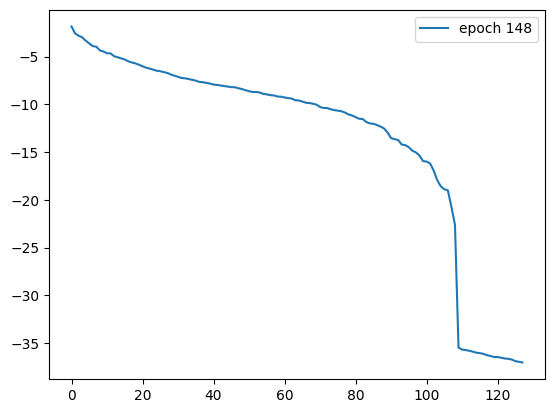

In [72]:
## Modality 2: CXR

e_cxr = np.array(z_cxr).T
cov_cxr = np.cov(e_cxr)
print(np.shape(cov_cxr))

u, s_cxr_1, vh = np.linalg.svd(cov_cxr, full_matrices=True)
#plt.plot(np.log(s_cxr), label='epoch 148')
plt.plot(np.log(s_cxr_1), label = 'epoch 148')
# plt.plot(np.log(s_cxr_3), label = 'epoch 100')
# plt.plot(np.log(s_cxr_4), label = 'epoch 50')

plt.legend()